<a href="https://colab.research.google.com/github/Suraj-Sedai/neural-signal-decoder/blob/main/notebook/Neural_Signal_Decoding_Simulated_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Signal Decoder (Simulated EEG)

This project explores how different neural network architectures perform on
simulated EEG data. We investigate how **data representation** and **model
inductive bias** affect learning, and demonstrate why frequency-domain features
are essential for EEG classification tasks.

Models explored:
- LSTM
- Transformer
- MLP (spectral features)

Key takeaway:
> Model choice must match the structure of the data.

In [56]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Problem Setup

We simulate EEG signals belonging to four frequency-based mental states:

| Class | Band   | Frequency Range (Hz) |
|------:|--------|----------------------|
| 0     | Alpha  | 8–12                 |
| 1     | Beta   | 13–30                |
| 2     | Theta  | 4–7                  |
| 3     | Gamma  | 30–45                |

Each sample consists of multiple EEG channels recorded over time.


## EEG Signal Simulation

We simulate multi-channel EEG signals using sinusoidal waves within
class-specific frequency bands, plus Gaussian noise.


In [57]:
FREQ_BANDS = {
    0: (8, 12),
    1: (13, 30),
    2: (4, 7),
    3: (30, 45),
}

def simulate_eeg_sample(class_id, num_channels, num_timesteps, sampling_rate=256):
    t = np.arange(num_timesteps) / sampling_rate
    signal = np.zeros((num_channels, num_timesteps))

    low_f, high_f = FREQ_BANDS[class_id]
    base_freq = np.random.uniform(low_f, high_f)

    for ch in range(num_channels):
        freq = base_freq + np.random.uniform(-0.3, 0.3)
        phase = np.random.uniform(0, 2 * np.pi)
        noise = 0.3 * np.random.randn(num_timesteps)

        signal[ch] = np.sin(2 * np.pi * freq * t + phase) + noise

    signal = (signal - signal.mean(axis=1, keepdims=True)) / (
        signal.std(axis=1, keepdims=True) + 1e-6
    )

    return signal

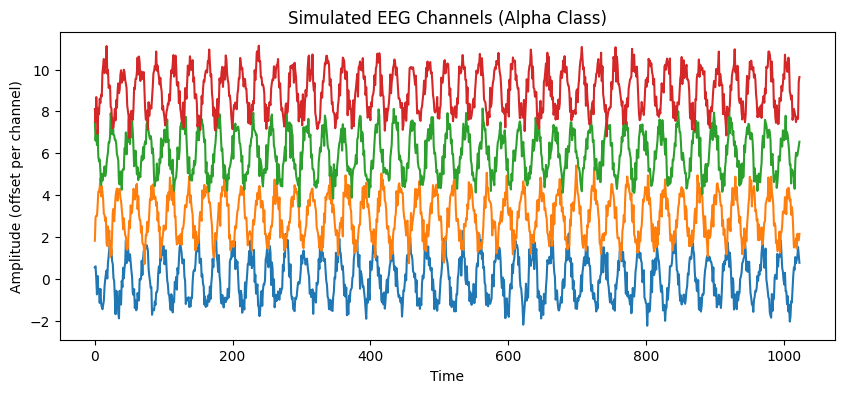

In [58]:
sample = simulate_eeg_sample(0, num_channels=4, num_timesteps=1024)

plt.figure(figsize=(10, 4))
for i in range(4):
    plt.plot(sample[i] + i * 3)
plt.title("Simulated EEG Channels (Alpha Class)")
plt.xlabel("Time")
plt.ylabel("Amplitude (offset per channel)")
plt.show()


## Dataset Construction

Signals are segmented into overlapping windows to increase the number of
training samples and mimic real EEG preprocessing pipelines.


In [59]:
def normalize_channels(signal: np.ndarray):
    """
    signal: np.ndarray of shape (C, T)

    returns:
        normalized_signal: np.ndarray of shape (C, T)
    """
    C, T = signal.shape
    normalized = np.zeros_like(signal)

    for c in range(C):
        mean = signal[c].mean()
        std = signal[c].std() + 1e-8
        normalized[c] = (signal[c] - mean) / std

    return normalized


In [60]:
def window_signal(signal: np.ndarray, window_size: int, stride: int):
    """
    signal: np.ndarray of shape (C, T)

    returns:
        windows: np.ndarray of shape (N, C, window_size)
    """
    C, T = signal.shape
    windows = []

    for start in range(0, T - window_size + 1, stride):
        end = start + window_size
        windows.append(signal[:, start:end])

    return np.stack(windows)


In [61]:
def to_spectral(window, sampling_rate=256, max_freq=60):
    """
    window: np.ndarray of shape (channels, time)
    returns: np.ndarray of shape (channels, freq_bins)
    """
    fft = np.abs(np.fft.rfft(window, axis=1))
    freqs = np.fft.rfftfreq(window.shape[1], d=1 / sampling_rate)
    return fft[:, freqs <= max_freq]


class SimulatedEEGDataset(Dataset):
    def __init__(
        self,
        num_samples_per_class: int,
        num_channels: int,
        total_timesteps: int,
        window_size: int,
        stride: int,
        sampling_rate: int = 256,
        max_freq: int = 60
    ):
        self.windows = []
        self.labels = []

        for class_id in range(4):
            for _ in range(num_samples_per_class):
                signal = simulate_eeg_sample(
                    class_id=class_id,
                    num_channels=num_channels,
                    num_timesteps=total_timesteps,
                    sampling_rate=sampling_rate
                )

                # Window in time domain
                windows = window_signal(signal, window_size, stride)

                for w in windows:
                    # Convert each window to spectral representation
                    w_spec = to_spectral(
                        w,
                        sampling_rate=sampling_rate,
                        max_freq=max_freq
                    )

                    self.windows.append(w_spec)
                    self.labels.append(class_id)

        self.windows = torch.tensor(self.windows, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.windows[idx], self.labels[idx]




## Initial Experiments (Time Domain)

We first trained:
- LSTM on raw time-domain windows
- Transformer on raw time-domain windows

### Observed Issues
- Class collapse
- One-class dominance
- Poor generalization

### Diagnosis
Time-domain signals hide the frequency structure critical for EEG decoding.
Models learned shortcuts instead of meaningful features.


## Frequency-Domain Features

EEG class information is encoded in frequency bands.
We therefore convert each window to its FFT magnitude representation.


In [62]:
def to_spectral(window, sampling_rate=256, max_freq=60):
    fft = np.abs(np.fft.rfft(window, axis=1))
    freqs = np.fft.rfftfreq(window.shape[1], d=1 / sampling_rate)
    return fft[:, freqs <= max_freq]


In [63]:
class SpectralMLP(nn.Module):
    def __init__(self, num_channels, freq_bins, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_channels * freq_bins, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [64]:
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = nn.functional.cross_entropy(logits, y)

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            total_loss += loss.item()

    return total_loss / len(loader), correct / total


Epoch [1/30] | Train Loss: 0.2940, Train Acc: 0.9554 | Val Loss: 0.0033, Val Acc: 0.9964
Epoch [2/30] | Train Loss: 0.0009, Train Acc: 0.9991 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [3/30] | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [4/30] | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [5/30] | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [6/30] | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [7/30] | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Early stopping triggered

FINAL TEST ACCURACY: 1.0
CONFUSION MATRIX:
[[57  0  0  0]
 [ 0 77  0  0]
 [ 0  0 74  0]
 [ 0  0  0 72]]


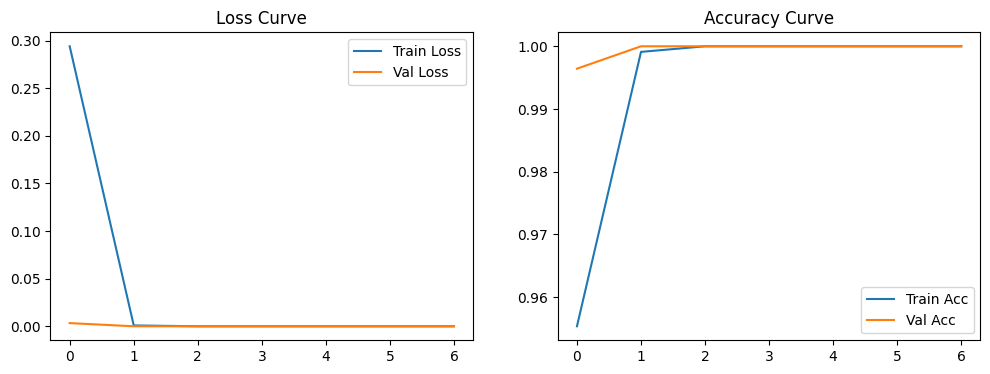

In [65]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---------------- DATA PARAMS ----------------
    num_channels = 16
    total_timesteps = 1024
    window_size = 256
    stride = 128
    num_samples_per_class = 50

    # ---------------- MODEL PARAMS ----------------
    num_classes = 4

    # ---------------- TRAINING PARAMS ----------------
    batch_size = 32
    learning_rate = 1e-3
    num_epochs = 30
    early_stop_patience = 5

    # ---------------- DATASET ----------------
    dataset = SimulatedEEGDataset(
        num_samples_per_class=num_samples_per_class,
        num_channels=num_channels,
        total_timesteps=total_timesteps,
        window_size=window_size,
        stride=stride
    )

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    x_sample, _ = dataset[0]
    freq_bins = x_sample.shape[1]

    # ---------------- MODEL ----------------
    model = SpectralMLP(
        num_channels=num_channels,
        freq_bins=freq_bins,
        num_classes=num_classes
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=2, factor=0.5
    )

    # ---------------- TRAINING LOOP ----------------
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        val_loss, val_acc = evaluate(model, test_loader, device)

        scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        # -------- Early stopping --------
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stop_patience:
            print("Early stopping triggered")
            break

    # ---------------- FINAL EVALUATION ----------------
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    test_acc = np.mean(np.array(all_preds) == np.array(all_labels))

    print("\nFINAL TEST ACCURACY:", test_acc)
    print("CONFUSION MATRIX:")
    print(cm)

    # ---------------- PLOTS ----------------
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.show()

if __name__ == "__main__":
    main()



## Results

- Train Accuracy: 100%
- Test Accuracy: 100%

Confusion matrix shows perfect class separation.


## Key Takeaways

1. Model performance depends strongly on data representation.
2. LSTMs and Transformers failed when their inductive bias mismatched the data.
3. Simple models outperform complex ones when features are well designed.
4. Frequency-domain features are essential for EEG classification.


## Future Work

- Replace simulated data with real EEG datasets
- Use bandpower features (Alpha/Beta/Theta/Gamma)
- Train a frequency-token Transformer
- Extend to regression or multi-label decoding
